# Code to create figure A.1.2 and A.1.3:
### ERA 5 and PRISM precipitation comparison: Monthly rainfall maps

Used in the manuscript,  
Evaporative Moisture Sources of Colorado’s Front Range: A Case Study of the Exceptionally Wet May-July Season of 2023

In [1]:
#Import Statements
import xarray as xr
import numpy as np
import xesmf as xe
import glob
import matplotlib.pyplot as plt
import matplotlib.colors 
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import warnings
from string import ascii_lowercase

warnings.filterwarnings("ignore") #ignore cartopy warnings when plotting

#data directories
prism_directory = '/Users/kathum/Research/COPEX/aggregated_files/prism'
era5_directory = '/Users/kathum/Research/COPEX/aggregated_files/era5'
#areagird directories
prism_area_path = '/Users/kathum/Research/area_grids/prism_4km_area.nc'
era5_area_path = '/Users/kathum/Research/area_grids/quarter_degree_area_grid_m_nHemisphere.nc'
#source region directories
region_mask_path = '/Users/kathum/Research/COPEX/aggregated_files/dryad_data_repo/region_masks/'

#function to extract dates from a PRISM file's pathname and assign a cordinate
def extract_date(ds):
    grid_time = pd.to_datetime(ds.encoding['source'].split('_')[-2],format="%Y%m")
 
    # print(grid_time)
    return ds.assign(time=grid_time)

#create a shaply feature from a shapefile path and a specific projection
def add_shapefile(path, projection):
    reader = shpreader.Reader(path)
    shapes = list(reader.geometries())
    shapely_shapes = cfeature.ShapelyFeature(shapes, projection)
    return shapely_shapes

#function to label subplots 
def label_subplots(axis, index):
    axis.text(0, 1.075, f'({ascii_lowercase[index]})', transform=axis.transAxes,fontsize=14, 
               va='top', ha='left', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

#automatically determine the appropriate extend for matplotlib colorbar   
def get_colorbar_extend(data, vmin_val, vmax_val):
    data_min = np.round(np.nanmin(data).item())
    data_max = np.nanmax(data).item()

    if data_min < vmin_val and data_max > vmax_val:
        return 'both'
    elif data_min < vmin_val:
        return 'min'
    elif data_max > vmax_val:
        return 'max'
    else:
        return 'neither'

## Read in PRISM and ERA5 datasets + other files needed for analysis

In [2]:
data_extent = [-111.0,-100.0,35,43] #min lon, max lon, min lat, max lat
colorado_extent = [-109.25, -101.75, 36.5, 41.5]
#---------------------------------Prism Data---------------------------------
#read prism area
prism_area_da = xr.open_dataarray(prism_area_path).sel(lon=slice(data_extent[0], data_extent[1]),lat=slice(data_extent[2], data_extent[3]))# in m^2

#read prism data and prep
files = sorted(glob.glob(f'{prism_directory}/PRISM_ppt_*_bil.nc'))
prism_ds_mm = xr.open_mfdataset(files,concat_dim='time',combine='nested',preprocess=extract_date)['Band1'].sel(lon=slice(data_extent[0], data_extent[1]),
                                                                                                            lat=slice(data_extent[2], data_extent[3]))
prism_ds_m3 = (prism_ds_mm/1000)*prism_area_da #in m^3

#---------------------------------Era5 Data---------------------------------
#read era5 area grid and prep
era5_area_da = xr.open_dataarray(era5_area_path).sel(longitude=slice(data_extent[0]+360, data_extent[1]+360),latitude=slice(data_extent[3], data_extent[2])) # in meters^2
era5_area_da = era5_area_da.rename({'latitude': 'lat', 'longitude': 'lon'}) #rename latitude and longitude variables to lat and lon

#read era5 and prep
files = sorted(glob.glob(f'{era5_directory}/*.nc'))
era5_ds_mm = (xr.open_mfdataset(files)['tp']*1000).sel(longitude=slice(data_extent[0]+360, data_extent[1]+360),latitude=slice(data_extent[3], data_extent[2])) #in meters
era5_ds_mm = era5_ds_mm.rename({'latitude': 'lat', 'longitude': 'lon'}) #rename latitude and longitude variables
era5_ds_m3 = (era5_ds_mm/1000 )* era5_area_da #in m^3

#---------------------------------Create region masks for eastern colorado and nfr---------------------------------
#read masks/create eastern co mask
era5_nfr_mask = xr.open_dataarray(f'{region_mask_path}co_AltClimate_Northern_Front_Range_source_region.nc')

#initialize eastern co mask with nfr mask
era5_eco_mask = era5_nfr_mask

#loop through sink regions and add them to nfr mask to create all eastern co mask
east_co_regions = ['Northeast', 'Pikes_Peak', 'South_Park', 'Southeast'] #without front rnge
files = []
for east_co_region in east_co_regions:
    filepath = f'{region_mask_path}/co_AltClimate_{east_co_region}_source_region.nc'
    region_mask = xr.open_dataarray(filepath)
    era5_eco_mask += region_mask
    region_mask.close()

#clean up masks, clip to same domain as rainfall data
era5_eco_mask = era5_eco_mask.sel(longitude=slice(data_extent[0]+360, data_extent[1]+360),latitude=slice(data_extent[3], data_extent[2]))
era5_eco_mask = era5_eco_mask.rename({'latitude': 'lat', 'longitude': 'lon'})

#---------------------------------Read counties shapefiles for plotting---------------------------------
CO_counties = add_shapefile('/Users/kathum/Research/COPEX/sink_region_files/sink_region_shp/lm_cnty/lm_cnty.shp',ccrs.PlateCarree())

#---------------------------------Regrid prism data---------------------------------
# Create regridder (assumes lat/lon names are standard: lat, lon)
regridder = xe.Regridder(prism_ds_mm, era5_ds_mm, method='conservative')
#regrid preism data to era5
prism_ds_coarse = regridder(prism_ds_mm) #coarse mm
prism_ds_coarse_m3 = ((prism_ds_coarse/1000)*era5_area_da)


## Plot May-July monthly precip map (A.1.2)

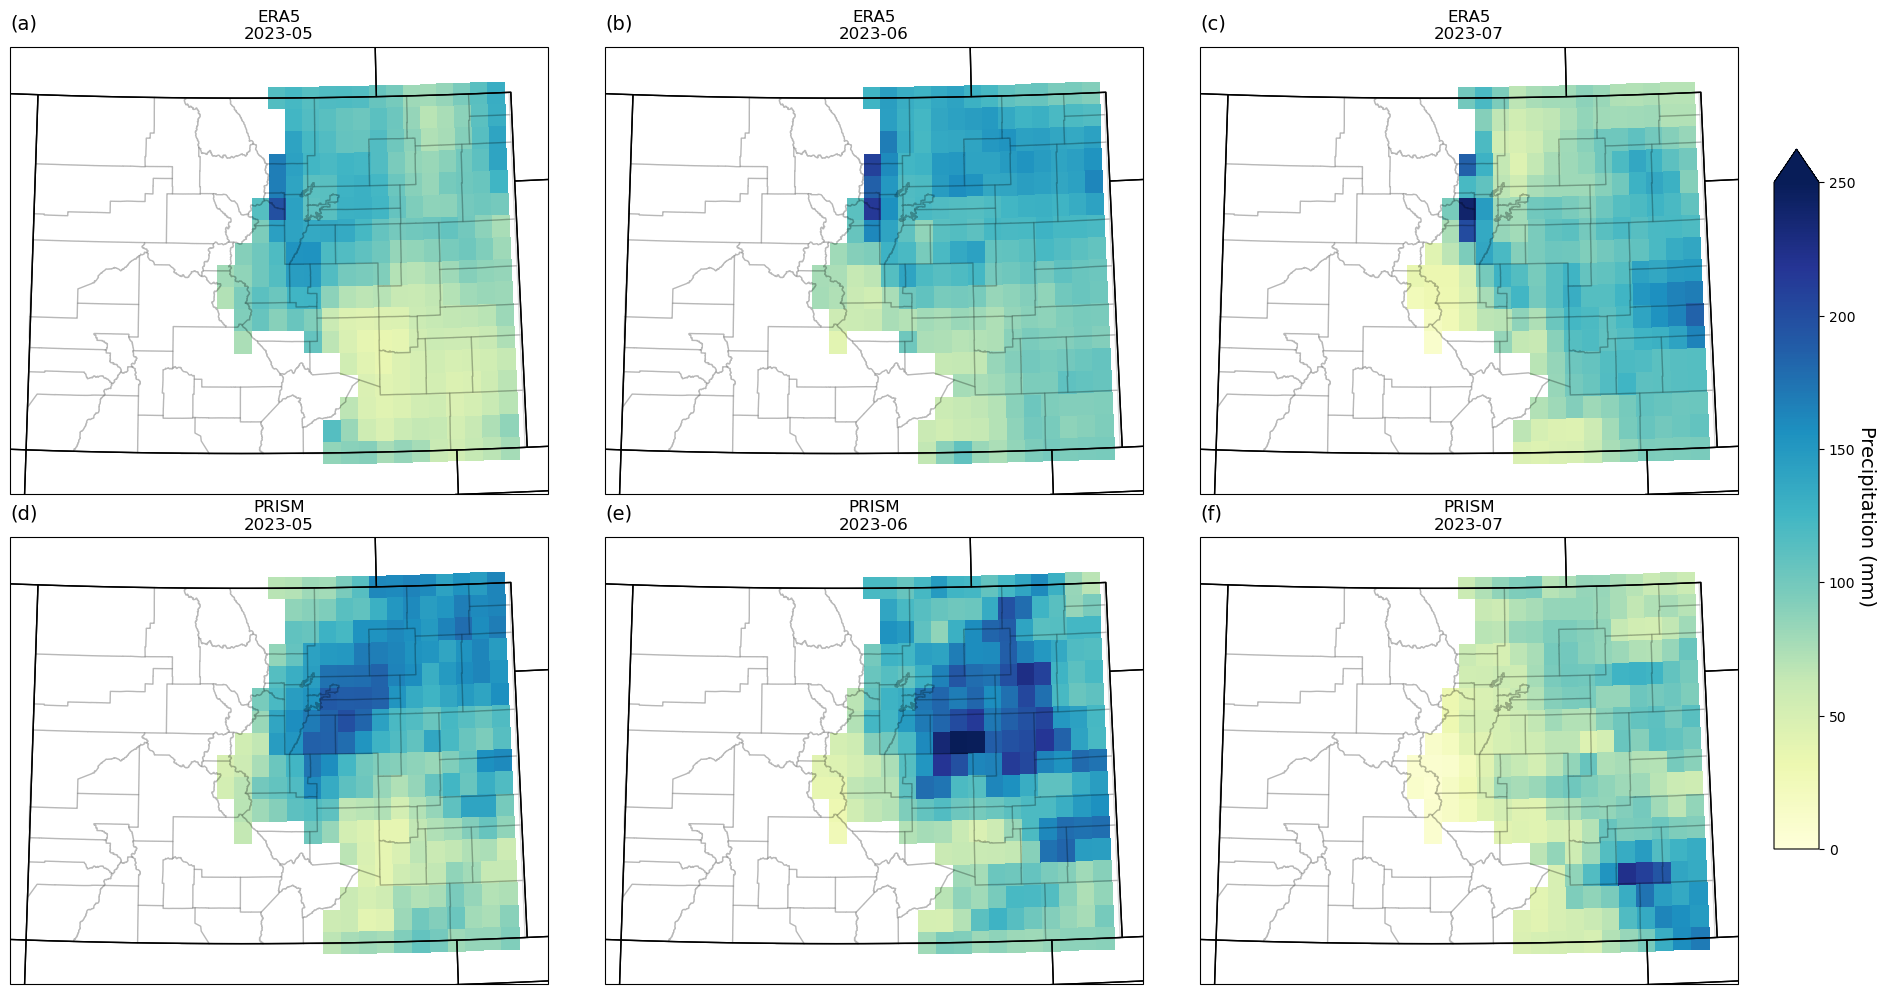

In [3]:
#MODIFY-------
vmin, vmax = (0,250) # Define levels for colorbar
#-------------
# Select may-july in 2023
era5_times = era5_ds_mm.sel(time=slice('2023-05-01', '2023-07-01'))
prism_times = prism_ds_coarse.sel(time=slice('2023-05-01', '2023-07-01'))

#save plotted data for anomaly calcuation later
plotted_data_list = []

#set up plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-106)})
axes = axes.flatten()  # Flatten 2D axes array to 1D for easy looping
plotted_data = np.array([0]) #initalize an array to collect all precip values for colorbar extend funct

# Loop through 6 subplots
for i in range(6):
    ax = axes[i]
    # Plot ERA5 (first 3 plots) or PRISM (last 3 plots)
    if i < 3:
        data = era5_times.isel(time=i)
        masked_data = (data*era5_eco_mask).where((data * era5_eco_mask) != 0, other=np.nan)
        img = ax.pcolormesh(
            data.lon,
            data.lat,
            masked_data,
            cmap='YlGnBu',
            vmin=vmin,
            vmax=vmax,
            transform=ccrs.PlateCarree()
        )               
        ax.set_title(f'ERA5\n{str(data.time.values)[:7]}')
        plotted_data = np.concatenate((plotted_data,masked_data.values.flatten()))
    else:
        data = prism_times.isel(time=i - 3)
        masked_data = (data*era5_eco_mask).where((data * era5_eco_mask) != 0, other=np.nan)
        img = ax.pcolormesh(
            data.lon,
            data.lat,
            masked_data,
            cmap='YlGnBu',
            vmin=vmin,
            vmax=vmax,
            transform=ccrs.PlateCarree()
        )
        ax.set_title(f'PRISM\n{str(data.time.values)[:7]}')
        plotted_data = np.concatenate((plotted_data,masked_data.values.flatten()))

    #save plotted data to list for anomaly calculation later
    plotted_data_list.append(data)
    
    # Shared formatting of all axes
    label_subplots(axis = ax, index = i)
    ax.set_extent(colorado_extent)
    ax.add_feature(CO_counties, facecolor='none', edgecolor='black', alpha=0.15)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
    
#shared colorbar
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7]) #place on the right hand side of the plot
cbar = fig.colorbar(img, cax=cbar_ax, extend = get_colorbar_extend(plotted_data, vmin, vmax))
cbar.set_label('Precipitation (mm)', fontsize=14, rotation=270, labelpad=15)
    
plt.tight_layout()
plt.savefig('/Users/kathum/Research/COPEX/figures/era5_prismregrid_MJJ2023.png',bbox_inches='tight',dpi=300)


## A.1.3

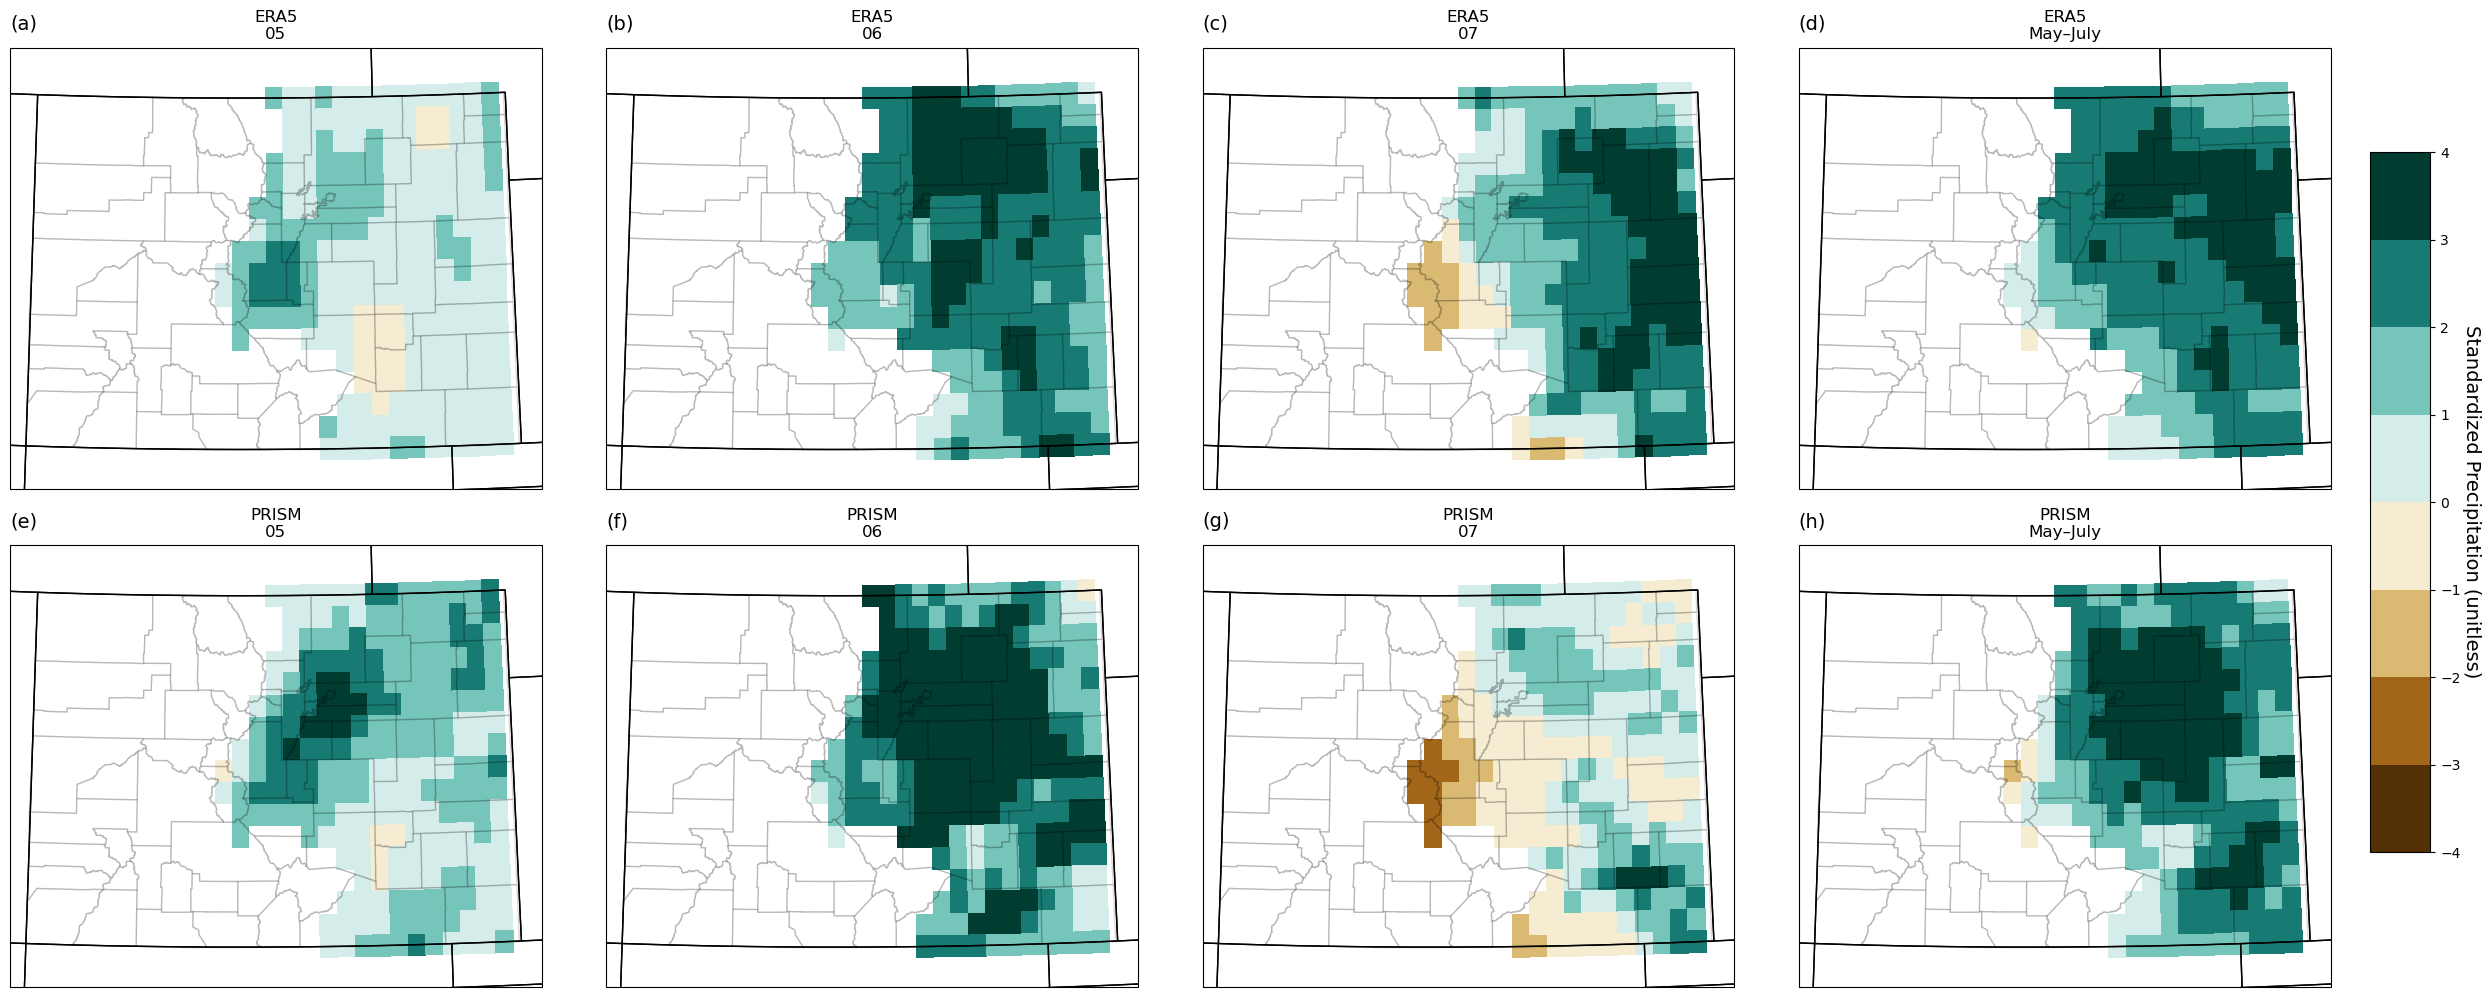

In [4]:
# Select only may-july months from all years except 2023
era5_monthly_mjj = era5_ds_mm.sel(time=era5_ds_mm.time.dt.month.isin([5, 6, 7]) & (era5_ds_mm.time.dt.year != 2023))
prism_monthly_mjj = prism_ds_coarse.sel(time=prism_ds_coarse.time.dt.month.isin([5, 6, 7]) & (prism_ds_coarse.time.dt.year != 2023))

era5_mjj_total = era5_monthly_mjj.groupby('time.year').sum(dim='time')
prism_mjj_total = prism_monthly_mjj.groupby('time.year').sum(dim='time')

plotted_data = np.array([0])  # initialize an array to collect all precip values for colorbar extend funct

# set up plot: 
fig, axes = plt.subplots(2, 4, figsize=(24, 10),
                         subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-106)})
axes = axes.flatten()  # Flatten 2D axes array to 1D for easy looping

# discrete sigma bins 
max_sigma_num = 4
levels_edges = np.arange(-max_sigma_num, max_sigma_num+1, 1)
cmap = plt.get_cmap("BrBG", len(levels_edges)-1)  
norm = matplotlib.colors.BoundaryNorm(boundaries=levels_edges, ncolors=cmap.N, clip=False)

months = [5, 6, 7]

# loop through 8 subplots
for i in range(8):
    ax = axes[i]
    
    if i < 3:  # ERA5 individual months
        month = months[i]
        avg_precip = era5_monthly_mjj.sel(time=era5_monthly_mjj.time.dt.month==month).mean(dim='time')
        std_precip = era5_monthly_mjj.sel(time=era5_monthly_mjj.time.dt.month==month).std(dim='time')
        data_2023 = era5_ds_mm.sel(time=era5_ds_mm.time.dt.month.isin([month]) & (era5_ds_mm.time.dt.year == 2023))
        data = (data_2023 - avg_precip) / std_precip
        title = f'ERA5\n{month:02}'
        
    elif i == 3:  # ERA5 May–July combined
        avg_precip = era5_mjj_total.mean(dim='year')
        std_precip = era5_mjj_total.std(dim='year')
        data_2023 = era5_ds_mm.sel(time=era5_ds_mm.time.dt.month.isin([5,6,7]) & (era5_ds_mm.time.dt.year == 2023)).sum(dim='time')
        data = (data_2023 - avg_precip) / std_precip
        title = 'ERA5\nMay–July'
        
    elif 4 <= i < 7:  # PRISM individual months
        month = months[i-4]
        avg_precip = prism_monthly_mjj.sel(time=prism_monthly_mjj.time.dt.month==month).mean(dim='time')
        std_precip = prism_monthly_mjj.sel(time=prism_monthly_mjj.time.dt.month==month).std(dim='time')
        data_2023 = prism_ds_coarse.sel(time=prism_ds_coarse.time.dt.month.isin([month]) & (prism_ds_coarse.time.dt.year == 2023))
        data = (data_2023 - avg_precip) / std_precip
        title = f'\nPRISM\n{month:02}'
        
    else:  # PRISM May–July combined
        avg_precip = prism_mjj_total.mean(dim='year')
        std_precip = prism_mjj_total.std(dim='year')
        data_2023 = prism_ds_coarse.sel(time=prism_ds_coarse.time.dt.month.isin([5,6,7]) & (prism_ds_coarse.time.dt.year == 2023)).sum(dim='time')
        data = (data_2023 - avg_precip) / std_precip
        title = '\nPRISM\nMay–July'

    # apply eastern colorado mask
    masked_data = (data * era5_eco_mask).where((data * era5_eco_mask) != 0, other=np.nan)
    img = ax.pcolormesh(
        data.lon,
        data.lat,
        masked_data.squeeze(),
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree()
    )
    
    ax.set_title(title)
    plotted_data = np.concatenate((plotted_data, masked_data.values.flatten()))
    label_subplots(axis=ax, index=i)
    ax.set_extent(colorado_extent)
    ax.add_feature(CO_counties, facecolor='none', edgecolor='black', alpha=0.15)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')

# shared colorbar
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cbar = fig.colorbar(
    img,
    cax=cbar_ax,
    boundaries=levels_edges,
    ticks=np.arange(-max_sigma_num, max_sigma_num + 1, 1),   # tick marks at each sigma
    spacing='proportional',
)
cbar.set_label('Standardized Precipitation (unitless)', fontsize=14, rotation=270, labelpad=15)

plt.tight_layout()

save_name = '/Users/kathum/Research/COPEX/figures/era5_prism_MJJstd_anomalies_8plots.png'
plt.savefig(save_name, bbox_inches='tight', dpi=300)
